In [1]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from knlms import *
from krls import *
from krls_rff import *
from klms import *
from klms_rff import *
from knlms_rff import *
from kernel import Kernel

# Multiprocessing
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [2]:
def generate_data(num_data):
    # AWGN
    v = 0.1*np.random.normal(0,1,num_data+2) 

    # Initial conditions
    d_true =[0.1 , 0.1]
    d = [d_true[0] + v[0], d_true[1] + v[1]]

    # Grab new data
    new_d_true = lambda d: d.append((0.8 - 0.5 * np.exp(-(d[-1]**2)))*d[-1] - (0.3 + 0.9*np.exp(-(d[-1]**2)))*d[-2] + 0.1*np.sin(np.pi*d[-1]))
    for i in range(2,num_data+2):
        new_d_true(d_true)
        d.append(d_true[-1] + v[i])

    u = np.hstack((np.array(d[0:num_data]).reshape(num_data,1),np.array(d[1:num_data+1]).reshape(num_data,1)))
    d_true = d_true[2::]
    d = d[2::]
    return np.array(u), np.array(d),np.array(d_true)

# Parameters
num_data = 3000
kernel = Kernel(3.73)
K = 10 # K edge clients
step_size = 0.79
reg_coeff = 0.03
threshold = 0.5

In [3]:
edge_update = [0] * K 
min_updates = 10

u,d,d_true = generate_data(num_data)

# generating data
# Data prepocessing for K clients
edges_u = []
edges_d = []
edges_d_true = []
for k in range(K):
    u,d,d_true = generate_data(num_data)
    
    edges_u.append(np.array(u))
    edges_d.append(np.array(d))
    edges_d_true.append(np.array(d_true))

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 17018.02it/s]


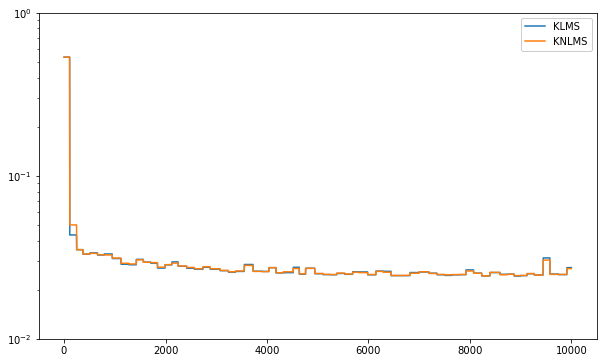

In [4]:
# Federated learning: Asynchronous updating rule

l = 500 # l updates for synchronous
c =  np.ones(K).reshape(K,1)/K # edge weighting
D = 200 # Dictionary size

iteration = 10000

#klms
klms_alpha_0 = np.zeros((D,1))
klms_alphas = np.zeros((K,D))

#knlms
knlms_alpha_0 = np.zeros((D,1))
knlms_alphas = np.zeros((K,D))

# Process data and kernel
u,d,d_true = generate_data(num_data)

klms_mse = [np.var(d)]
knlms_mse = [np.var(d)]

sigma = 1/np.sqrt(2*kernel.sigma)
W = (1/sigma) * np.random.normal(loc=0, scale=sigma, size=(2,D))
b = np.random.uniform(0,2*np.pi,D).reshape(D,1)
h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)
for n in tqdm(range(iteration)):

    # Local updates
    i = np.random.randint(0,num_data)
    edge = np.random.randint(0,K)

    klms_alpha_k = klms_alphas[edge].reshape((D,1))
    knlms_alpha_k = knlms_alphas[edge].reshape((D,1))
    
    u_k = u[i]
    h_k = h[:,i].reshape((D,1))
    d_k = np.array([d[i]])
    # err = d_k - h_k.T @ alpha_k
    # alpha_step = alpha_k + step_size * err * h_k
    
    klms_err ,klms_alpha_step = KLMS_RFF(u_k,d_k,h_k,step_size,D,alpha_0=klms_alpha_k)
    knlms_err ,knlms_alpha_step = KNLMS_RFF(u_k,d_k,h_k,step_size,0.1,D,alpha_0=knlms_alpha_k)
    
    edge_update[edge] = edge_update[edge] + 1
    
    klms_alphas[edge] = klms_alpha_step.T
    knlms_alphas[edge] = knlms_alpha_step.T

    glob = 1
    # check to see if we need a global update
    for m in range(len(edge_update)):
        if edge_update[m] < min_updates:
            glob = 0
    
    # Global update iff all edges have at least min_updates
    if glob == 1:
#         print(n)
        klms_alpha = (klms_alphas.T @ c)
        knlms_alpha = (knlms_alphas.T @ c)
    
        klms_alphas = np.repeat(klms_alpha,K,axis=1).T
        knlms_alphas = np.repeat(knlms_alpha,K,axis=1).T
        
        klms_mse.append(np.square(np.linalg.norm(d[-500::].reshape(500,1) - h.T[-500::] @ klms_alpha))/500)
        knlms_mse.append(np.square(np.linalg.norm(d[-500::].reshape(500,1) - h.T[-500::] @ knlms_alpha))/500)
        
        edge_update = [0] * K
        
    elif n > 1:
        klms_mse.append(klms_mse[-1])
        knlms_mse.append(knlms_mse[-1])

plt.figure(figsize=(10, 6))
plt.semilogy(range(len(klms_mse)),klms_mse, label='KLMS')
plt.semilogy(range(len(knlms_mse)),knlms_mse, label='KNLMS')
plt.ylim([1e-2,1e0])
plt.legend(framealpha=1, frameon=True);